# 第6回のコード

Juliaの実装を紹介する。

なおこのコードの実行の前に以下のパッケージをインストールする必要がある。

```
using Pkg
Pkg.add("IJulia")
Pkg.add("FFTW")
Pkg.add("Plots")
Pkg.add("ApproxFun")
Pkg.add("SpecialFunctions")

```

## エイリアシング

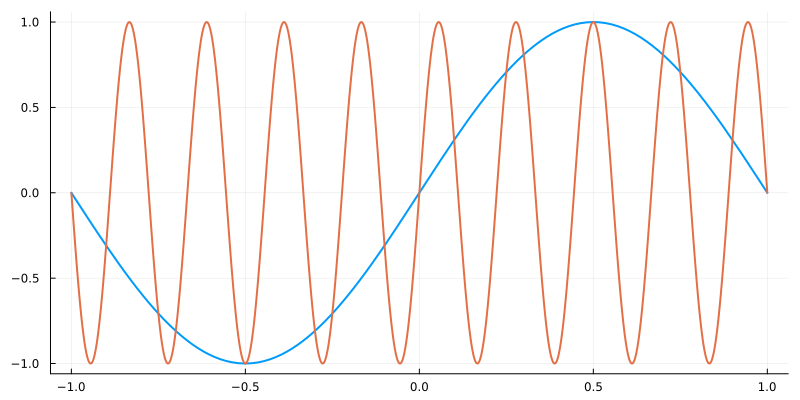

In [1]:
using Plots

f₁ = x->sinpi(x)
f₂ = x->sinpi(9x)

plot(f₁,-1,1,
    line       = 2,
    size       = (800,400),
    legend     = false,
)

plot!(f₂,-1,1,line=2)
# savefig("chebcoeffs.pdf")

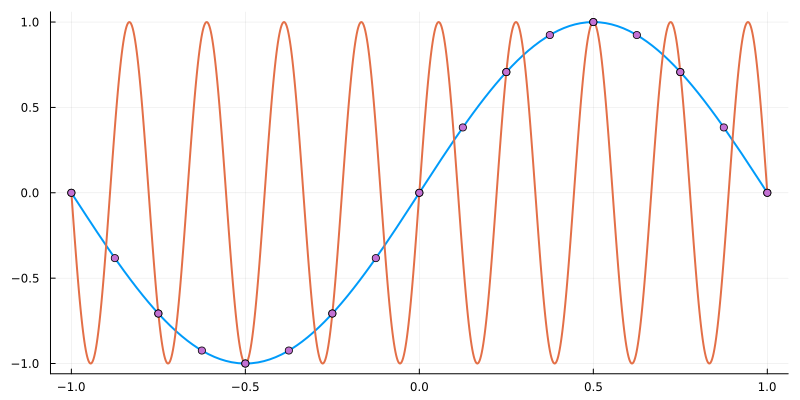

In [3]:
x = -1:0.125:1
scatter!(x,f₁.(x))
# savefig("aliasing.pdf")

## 具体例（フーリエ級数）

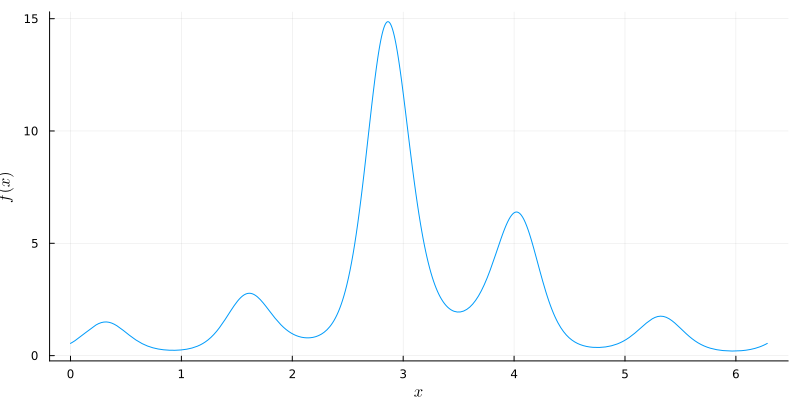

In [4]:
include("FourierChebyshev.jl")
#f(x)の概形
f(x) = exp(sin(5x))/(1+sin(cos(x)))
plot(f,0,2π,size=(800,400),legend=false,xlabel="\$x\$", ylabel="\$f(x)\$")

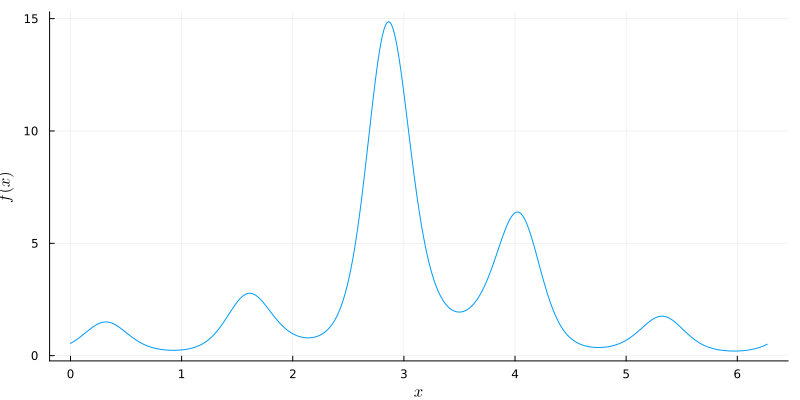

In [5]:
using ApproxFun
fc = Fun(f,Laurent())
plot(real(fc),size=(800,400),legend=false,xlabel="\$x\$", ylabel="\$f(x)\$")

In [9]:
M

72

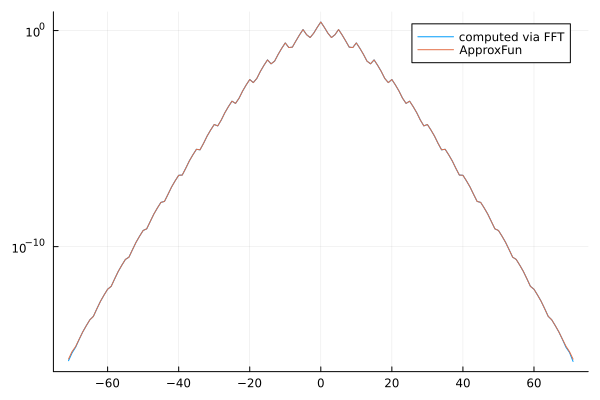

In [6]:
m = ncoefficients(fc)
M = Int((m+1)/2)
c = coefficients(fc) # coefficients of ApproxFun
function index_shift(c) # convert c -> fourier coeffs
    return [reverse(c[2:2:end]);c[1:2:end]]
end
a = fouriercoeffs(f,M)
plot(-M+1:M-1, abs.(a),yscale=:log10,label="computed via FFT")
plot!(-M+1:M-1, abs.(index_shift(c)),yscale=:log10,label = "ApproxFun")
# savefig("fouriercoeffs.pdf")

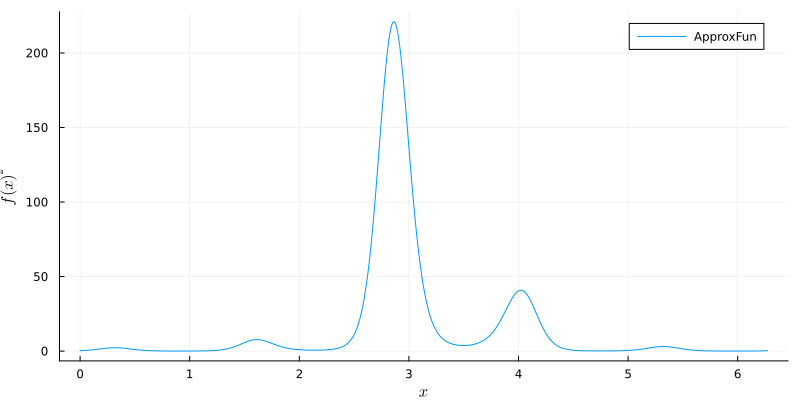

In [7]:
plot(real(fc)^2,size=(800,400),xlabel="\$x\$", ylabel="\$f(x)^2\$",label = "ApproxFun")

In [11]:
fftshift(ifftshift(-3:3))

7-element Vector{Int64}:
 -3
 -2
 -1
  0
  1
  2
  3

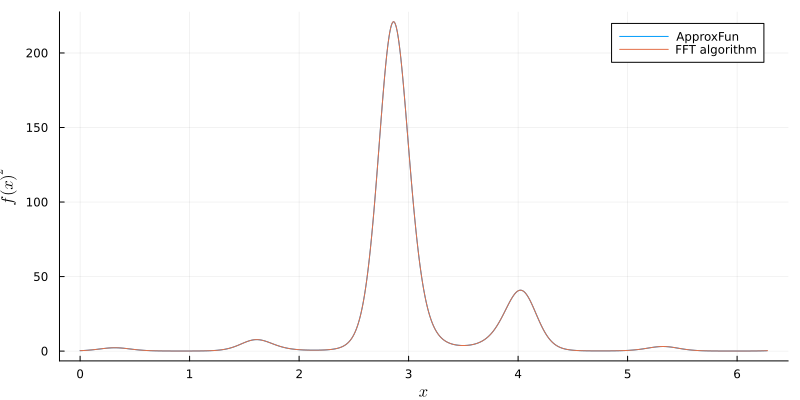

In [12]:
# FFT Algorithm
p = 2
N = (p-1)*M
ta = [zeros(N);a;zeros(N)] # 1. Padding zeros
tb = ifft(ifftshift(ta)) # 2. IFFT of ta
tbᵖ = tb.^p # 3. tb*^tb
cᵖ = fftshift(fft(tbᵖ))*(2.0*p*M-1)^(p-1) # 4. FFT of tb2 
plot_fourier!(cᵖ[p:end-(p-1)],label="FFT algorithm")

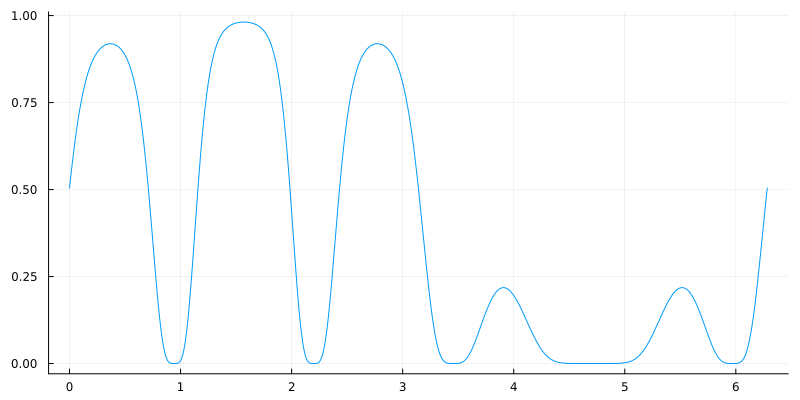

In [13]:
using SpecialFunctions
f(x) = erf(sin(3x)+cos(2x))^4
plot(f, 0, 2π, legend=false, size=(800,400))

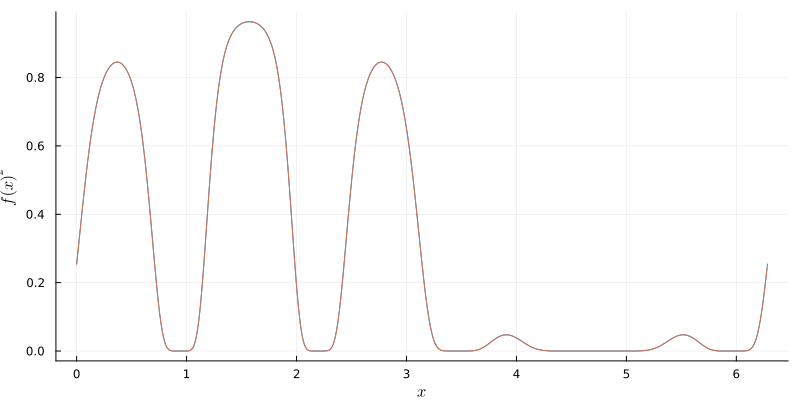

In [16]:
M = 150
p = 2
# f(x) = erf(sin(3x)+cos(2x))^4
g(x) = f(x)^p
plot(g,0,2π,size=(800,400),legend=false,xlabel="\$x\$", ylabel="\$f(x)^{$(p)}\$")

a = fouriercoeffs(f,M) # size(a) = 2M-1
# plot(abs.(a),yscale=:log10,)
function powerconvfourier(a::Vector{Complex{T}},p) where T
    M = Int((length(a)+1)/2)
    N = (p-1)*M
    ta = [zeros(N);a;zeros(N)] # 1. Padding zeros: size(ta) = 2pM-1
    tb = ifft(ifftshift(ta)) # 2. IFFT of ta
    tbᵖ = tb.^p # 3. tb*^tb
    cᵖ = fftshift(fft(tbᵖ))*(2.0*p*M-1)^(p-1)
    return cᵖ[N+1:end-N], cᵖ[p:end-(p-1)]# return (truncated, full) version
end

ap, ap_full = powerconvfourier(a,p)
plot_fourier!(ap_full)

## 具体例（チェビシェフ級数）

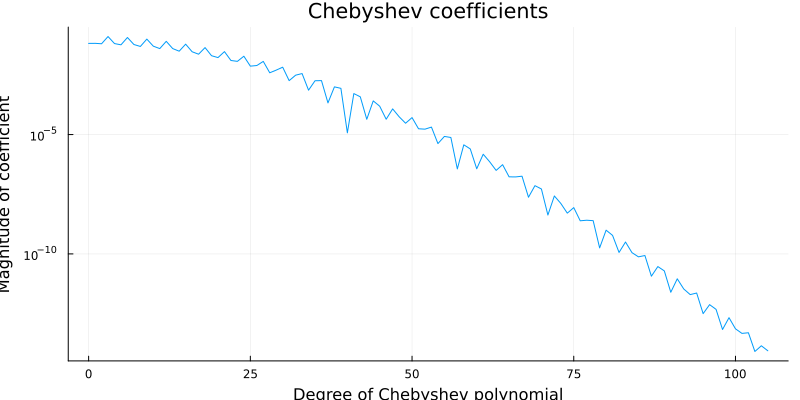

In [31]:
# a = fouriercoeffs(f,150)
# plot_fourier(a)
# plot_fouriercoeffs(a)
plot_chebcoeffs(a)

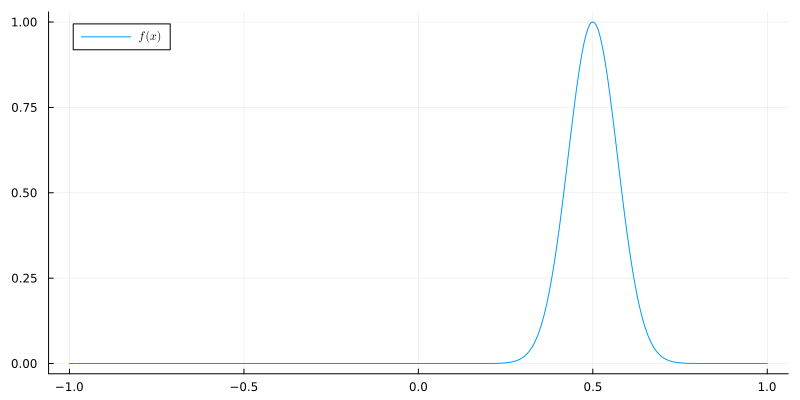

In [33]:
f(x) = exp(-(100*(x-0.5)^2))
plot(f,-1,1,label="\$f(x)\$",size=(800,400))

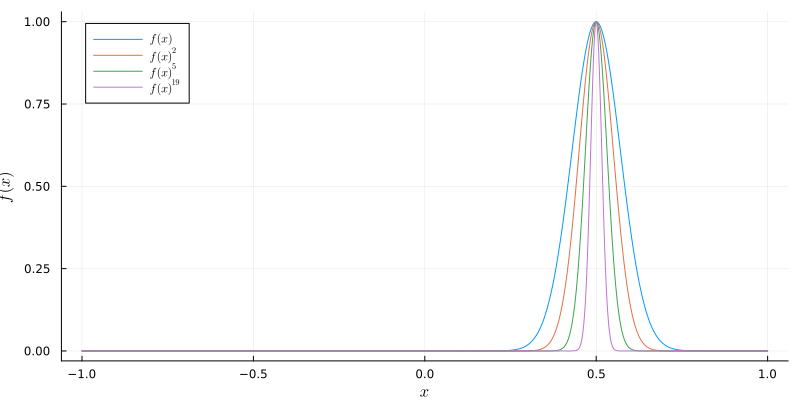

In [36]:
a = cheb(f) # Two-sided
M = length(a); p = 19

c = zeros(size(a))
c[1] = a[1]; c[2:end] = 0.5 * a[2:end] # Two-sided -> One-sided

FourierCoeffs = [reverse(c[2:end]); c]
cp, cp_full = powerconvfourier(complex(FourierCoeffs),p)

a[1] = real(cp[M]); a[2:end] = 2 * real(cp[M+1:end]) # One-sided -> Two-sided
N = Int((length(cp_full)+1)/2) #2N-1
a_full = zeros(N)
a_full[1] = real(cp_full[N]); a_full[2:end] = 2 * real(cp_full[N+1:end]) # One-sided -> Two-sided

plot_cheb!(a_full,label="\$f(x)^{$p}\$")

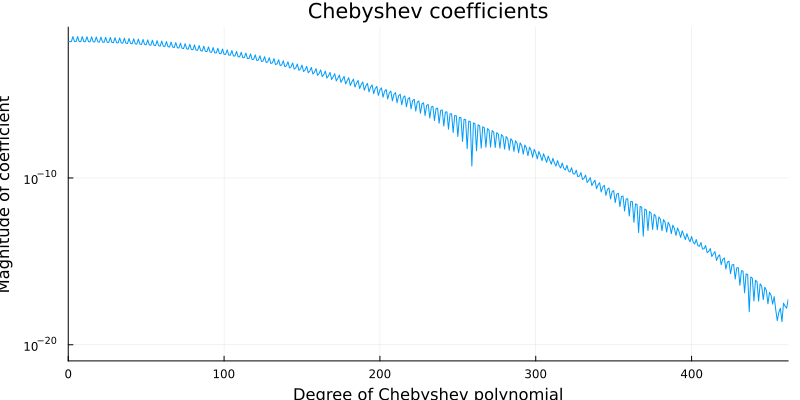

In [37]:
plot(plot_chebcoeffs(a_full),xlims=[0,462])

## 応用（ApproxFunによる近似解の残差評価）

$$
\frac{du}{dt} = u - u^p + u^r,\quad u(0)=0.5
$$

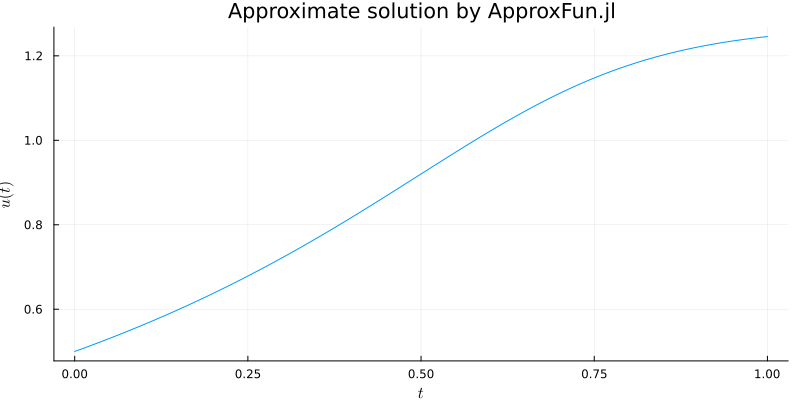

In [42]:
using ApproxFun, Plots
tmax = 1
p = 5
r = 3
x  = Fun(identity, 0..tmax)
u₀ = 0.5x # initial guess
N = u -> [u(0)-0.5, u' - u + u^p - u^r]
u = newton(N, u₀) # perform Newton iteration in function space
plot(u,
    title="Approximate solution by ApproxFun.jl",
    xlabel="\$t\$",
    ylabel="\$u(t)\$",
    size       = (800,400),
    legend     = false,
)
# savefig("appsol_by_approxfun.pdf")

In [39]:
function powerconvcheb(c,p)
    M = length(c)
    a = [reverse(0.5*c[2:end]); c[1]; 0.5*c[2:end]]# Fourier coefficient
    N = (p-1)*M
    ta = [zeros(N,1);a;zeros(N,1)] # 1. Padding zeros
    tb = ifft(ifftshift(ta)) # 2. IFFT of ta
    tbᵖ = tb.^p # 3. tb*^tb
    cᵖ = real(fftshift(fft(tbᵖ))*(2.0*p*M-1)^(p-1)) # 4. FFT of tb2
    return [cᵖ[N+M]; 2*cᵖ[N+M+1:N+M+p*(M-1)]]# return Chebyshev coefficients
end

function chebdiff(c)
# NOTE: remind dividing by the rescaling factor (tmax/2)!
    size_of_c = size(c)
    if length(size_of_c) > 1
        n, m = size_of_c
    else
        n = size_of_c[1]; m=1
    end
    cout = zeros(n-1, m)
    w = repeat(2.0*(1:n-1), 1, m)
    v = w.*c[2:end,:]
    cout[n-1:-2:1,:] = cumsum(v[n-1:-2:1,:],dims=1)
    cout[n-2:-2:1,:] = cumsum(v[n-2:-2:1,:],dims=1)
    cout[1,:] = .5*cout[1,:]
    return cout
end

chebdiff (generic function with 1 method)

In [43]:
using LinearAlgebra, FFTW
uc = coefficients(u)
M = ncoefficients(u)
N = (p-1)*M

ucᵖ = powerconvcheb(uc,p)
ucʳ = powerconvcheb(uc,r)

if p >= r
    L = length(ucᵖ)-length(ucʳ)
    ucʳ = [ucʳ; zeros(L)];
else
    L = length(ucʳ)-length(ucᵖ)
    ucᵖ = [ucᵖ; zeros(L)]
end

#### 
# Differentiate the Chebyshev series by ApproxFun
du = differentiate(u)
duc = coefficients(du)
duc = [duc; zeros((p-1)*(M-1)+1,1)]

# Differentiate the Chebyshev series by coefficients
rescaleFactork = tmax/2.0
duc2 = chebdiff(uc)/rescaleFactork
duc2 = [duc2; zeros((p-1)*(M-1)+1)]
norm(duc-duc2,1)
# reshape([duc;duc2],length(duc),2)

0.0

In [44]:
uc = [uc;zeros((p-1)*(M-1))]
res = duc2 - uc + ucᵖ - ucʳ
norm(res,1)

1.0146747779604821e-13